![banner](./images/banner.png "banner")

[Fuente de la imagen](https://unsplash.com/photos/Hcfwew744z4)
<a name='toc' />

# <font color=#ac6240>Cuantificación de la incertidumbre en la clasificación multiclase
</font>

### <font color=#ac6240>Tabla de Contenidos</font>

<a href=#pre>Requisitos previos</a><br>
1. <a href=#project-description>Descripción del proyecto</a><br>
    1.1 <a href=#project-description-intro>Introducción</a><br>
    1.2 <a href=#project-description-goal>Objetivo</a><br>
    1.3 <a href=#project-description-data>Datos y modelo de aprendizaje automático</a><br>
    1.4 <a href=#project-description-software>Software</a><br>
2. <a href=#prep>Preparación de los datos</a><br>
    2.1 <a href=#prep-clean> Limpieza de los datos</a><br>
    2.2 <a href=#prep-split> Division de los datos en conjuntos de datos de entrenamiento, validación y prueba</a><br>
    2.3 <a href=#prep-encoding> Codificación y normalización de las 'features'</a><br>
3. <a href=#model-ml> Entrenamiento y testado del modelo de aprendizaje automático</a><br>
4. <a href=#app-uq>Aplicación de métodos de cuantificación de incertidumbre</a><br>
    4.1 <a href=#uq-cp> Conformal Predictors </a><br>
    
5. <a href=#uq-end>Conclusión sobre la cuantificación de incertidumbre</a><br>

<a name='pre'/>

## <font color=#ac6240>Requisitos previos</font>

Este Jupyter Notebook es la continuación de los Jupyter Notebooks de [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI):
+ `Exploration_and_Classification.ipynb` donde explicamos cómo explorar exhaustivamente los datos de pacientes que sufrieron o no fallo cardíaco y cómo ajustar el umbral de decisión, y evaluar la calidad de un modelo de aprendizaje automático supervisado con métricas de rendimiento; elegimos el modelo que mejor se comportaba para este proyecto de predicción de fallo cardíaco y era un bosque aleatorio, 
+ `XAI.ipynb` donde aplicamos varios métodos de explicabilidad sobre las predicciones de ese bosque aleatorio para entender en qué se fijó el modelo para clasificar a les pacientes, y
+ `UQ.ipynb` donde explicamos la cuantificación de incertidumbre para esa tarea de clasificación binaria.

En este Jupyter Notebook aplicamos UQ para una clasificación multiclase. La introducción teórica es la misma que en el anterior Jupyter Notebook sobre UQ.

<font size="5"> 👍🤓</font>

<a name='project-description'/>

##  <font color=#ac6240>1. Descripción del proyecto</font>

<a name='project-description-intro'/>

### <font color=#ac6240>1.1 Introducción</font>

Estamos acostumbrades a modelos de aprendizaje automático que nos devuelven una predicción en forma de un único valor puntual ('single-value prediction'). Estos modelos no tienen ninguna manera de manifestar si están muy seguros o no de lo que predicen, por ejemplo, proporcionando una distribución o rango de resultados razonables, para que podamos representar la predicción con unas 'barras de error' en lugar de con un solo punto. 

La falta de información sobre la certeza que tiene un modelo sobre los resultados que arroja es especialmente problemático cuando:
+ el modelo no es interpretable, es una 'black box' o caja opaca, (explicamos estos conceptos en el Jupyter Notebook anterior `XAI.ipynb`), o
+ pedimos al modelo que prediga un resultado sobre una instancia anómala ('outlier') que no se parece a los datos históricos con los que ese modelo fue entrenado, algo relacionado con el fenómeno denominado ['drift'](https://en.wikipedia.org/wiki/Drift_(data_science)) (más info sobre la definición de 'deriva' o 'drift' y sus diferentes tipos, [aquí](https://analyticsindiamag.com/concept-drift-vs-data-drift-in-machine-learning/)), lo cual es indeseado y puede pasar fácilmente desapercibido. 

Por ejemplo, supongamos que entrenamos una red neuronal artificial (que no es interpretable) con imágenes de perres y gates con la tarea de distinguir entre perres y gates. Digamos que el umbral de decisión es tal que las instancias, es decir, las fotos, cuya 'raw score' sea mayor de 0.5 serán clasificadas como gates y el resto como perres, como en una típica clasificación binaria. Supongamos además que conseguimos que la red neuronal artificial tenga un rendimiento excelente sobre los datos de entrenamiento y validación, puede que incluso tenga un 99.5% en 'accuracy' sobre ambos conjuntos. Ahora, aplicamos la red y le pedimos que clasifique las fotos que vemos un poco más abajo y :
+ para la foto de la izquierda nos da una 'raw score' de 0.9, así que predice correctamente que es la imagen de une gate,
+ para la foto del centro obtenemos una 'raw score' de 0.5, y a la vista de la imagen _interpretamos_ que a la red le costó darnos una clasificación correcta (nos la dió por los pelos) y que obviamente no está _tan segura_ porque le perre de la imagen parece un poco une gate, pero...

¿y si le pedimos que clasifique la figura de la derecha? Cualquier cosa puede pasar, nos puede dar una 'raw score' por encima o por debajo de 0.5 o exactamente 0.5, pero en cualquier caso, sabemos que no es fiable. Y la cuestión es que **el modelo de aprendizaje automático no nos podría decir 'hey, no tengo ni idea' porque las 'raw scores' no muestran certidumbre**, a pesar de lo que todes hemos erróneamente interpretado alguna vez.  

![cat_dog_bird](./images/cat_dog_bird.png "cat_dog_bird")

[Fuente de la imagen: _"Are you sure about that?! Uncertainty Quantification in AI"_](https://florianwilhelm.info/2019/10/uncertainty_quantification_in_ai/)

En una tarea de regresión ocurre lo mismo. Entrenamos el modelo con un gran conjunto de datos de precios de casas y al aplicarlo sobre una casa nos da cómo resultado, por ejemplo, 135.896,73 euros. La probabilidad de que el precio verdadero de la casa sea ese es nula. Si el modelo rinde bien, el precio verdadero estará cerca de ese valor, estará dentro de un intervalo de predicción alrededor de ese valor. Cuanto más ancho el intervalo, más grande la incertidumbre.

Recordemos que los modelos de aprendizaje automático supervisado están diseñados para interpolar, **no para extrapolar, ni para identificar relaciones de causa-efecto, ni para abstraer conocimiento,... por lo cual les cuesta generalizar**. Si no damos al modelo la oportunidad de avisarnos de la incertidumbre, no sabremos cuándo no está preparado para desempeñar la tarea, nos dará igualmente una predicción, y tomaremos que está igual de seguro de esa predicción como lo está de la predicción de una instancia estándar para la que sí está entrenado y para la que sí arraja resultados fiables. Sería mucho más adecuado que el modelo de aprendizaje automático nos informara de la certeza de sus resultados.  

Es decir, saber qué no sabemos, es decir, cuantificar la incertidumbre, mejora la calidad de las decisiones para poder descartar las predicciones con alta incertidumbre y derivar las decisiones a expertes humanos, como ocurre a menudo en el denominado ['Active Learning'](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)).

#### <font color=#ac6240>1.1.1 Definición de Incertidumbre</font>

Según la Wikipedia en castellano (consultada el 26.09.2022):

![uncertainty_wp](./images/uncertainty_wp.png "uncertainty_wp")

[Fuente de la imagen](https://es.wikipedia.org/wiki/Incertidumbre)

Vamos, que el asunto va de lo que pasa cuando queremos medir u observar algo o predecir cuánto valdrá algo. 

Consultemos ahora a les expertes en [metrología](https://es.wikipedia.org/wiki/Metrolog%C3%ADa), es decir, la Oficina Internacional de Pesas y Medidas ([BIPM](https://www.bipm.org/en/committees/jc/jcgm/), por sus siglas en francés) cuyo Joint Committee for Guides in Metrology (JCGM) publica la Guía para la expresión de la Incertidumbre en la Medida (GUM, por sus siglas en inglés) que incluye el International Vocabulary of basic and general terms in Metrology ([VIM](https://www.bipm.org/en/committees/jc/jcgm/publications) JCGM_100_2008_E-1)

<font size="5">🤪🤯</font>


donde se define:

<blockquote>

**2.2 The term 'uncertainty'**

[...] Uncertainty (of measurement) [is a] parameter, associated with the result of a measurement, that characterizes the dispersion of the values that could reasonably be attributed to the measurand. [...] The parameter may be, for example, a standard deviation (or a given multiple of it), or the half-width of an interval having a stated level of confidence.
</blockquote>

y también:

<blockquote>
    
**3.3. Uncertainty**

The uncertainty of the result of a measurement reflects the lack of exact knowledge of the value of the measurand.
</blockquote>

Antes de ver qué significa esto en el contexto del aprendizaje automático, hagamos una aclaración importante para distinguir bien entre los conceptos de incentidumbre, error, residuo y sesgo o 'bias'.

#### <font color=#ac6240>1.1.2 Incertidumbre vs error vs residuo vs bias</font>

El **error** es la diferencia entre el valor verdadero, (asumiento que existe y se puede definir, ojo, que aquí esto es clave), y el valor resultado de la medición o predicción, por ejemplo, realizada empíricamente con un aparato de medida o en nuestro caso, el dato de si le paciente sufre o no fallo cardíaco. 

Si ese valor verdadero lo defimos por un modelo, esa diferencia entre la medición y el modelo también se llama **residuo**, por ejemplo, la distancia entre un punto `(x,y)` (el dato resultado de la medición) y la recta de regresión lineal que intenta representar a todos los datos, `y = mx + n`, y que idealizamos como representación de la realidad. Vimos la regresión lineal brevemente en la seccion 4.1 Modelo de referencia inicial para la selección de la métrica: Regresión Logística del Jupyter Notebook `Exploration_and_Classification.ipynb`.

Entonces, en la representacion tradicional, la desviación entre el valor obtenido de la medición y el ansiado supuesto valor verdadero se compone de dos tipos de errores:
+ el error aleatorio, la componente debida a la naturaleza [estocástica](https://en.wikipedia.org/wiki/Stochastic_process#Examples) del sistema, y
+ el error sistemático, también llamado **sesgo o 'bias'**, que es la componente reducible porque su media no es cero y se puede compensar con un 'factor de correccion' (mencionamos los problemas éticos del sesgo en IA en la intro del Jupyter Notebook `XAI.ipynb`).

En la Introducción del nuevo informe de 2012 [VIM 200:2012](https://www.bipm.org/en/committees/jc/jcgm/publications) se indica que estos dos tipos de errores no siempre son fáciles de diferenciar y que no disponemos de una regla general para ver cómo se combinan. Y también dice que normalmente estimamos el límite superior del valor absoluto del error total y que llamamos vagamente a eso 'incertidumbre'.

Pero la VIM también nos indica que es mejor no seguir ese punto de vista tradicional del 'error' porque:

+ necesita de la asumpción de la existencia un 'valor verdadero', y 
+ su objetivo es minimizar cualquier diferencia entre el resultado de la medida y ese supuesto 'valor verdadero', porque considera el error como una imperfección indeseable,

siendo más adecuado tratar la dispersión de los resultados de las mediciones como una 'incertidumbre' que:

+ aporta valiosa información y detalles significativos del comportamiento del sistema, y 
+ nos permite asumir que **la medición solo se puede expresar como un intervalo de valores razonables**.

<font size="5"> 👏 </font> 

Veamos ahora a qué nos referimos con "intervalo de valores razonable".

#### <font color=#ac6240>1.1.3 Intervalo de valores razonables</font>

Hay muchas maneras de definir qué entendemos por un 'intervalo de valores razonables' que nos permita cuantificar la variabilidad de los datos y por tanto, la incertidumbre de la medición.

Los métodos de UQ que aquí explicamos nos proveen de un [intervalo de predicción](https://en.wikipedia.org/wiki/Prediction_interval) para cada predicción, es decir, es una estimación del rango de valores que con la probabiliad que determinamos con el llamado 'nivel de confianza (por ejemplo, con 0.90 tendremos el 90% de probabilidad) incluirá el valor correcto de una futura medición. 

Centramos ahora en la incertidumbre en aprendizaje automático.

#### <font color=#ac6240>1.1.4 Incertidumbre en aprendizaje automático</font>

Cuando aplicamos un modelo de aprendizaje automático, queremos que nos diga cuándo no está seguro y cuánta incertidumbre está asociada a su predicción. 

Podriamos incluso intentar desglosar los tipos de incertidumbre según su origen. Por ejemplo, puede haber incertidumbre:
+ en cómo se tomaron y procesaron esos datos, (por ejemplo, la precisión de los aparatos de observación y medida, el etiquetado, el almacenamiento, ...), 
+ asociada al modelo (por ejemplo, en la elección del modelo, la estimación de parámetros, la regularizacion, ...), 
+ por culpa de los [sesgos cognitivos](https://www.visualcapitalist.com/50-cognitive-biases-in-the-modern-world/), el desconocimiento, y el error humano, 

y un millón de factores más, que a menudo en aplicaciones prácticas no hace falta analizar. El origen de la incertidumbre o los tipos de incertidumbres que cuantizamos con métodos de UQ es un tema demasiado complicado que requiere 'domain expertise'.

Simplemente mencionaremos que en aprendizaje automático se suelen considerar [dos tipos de incertidumbre](https://deepai.org/publication/aleatoric-and-epistemic-uncertainty-in-machine-learning-a-tutorial-introduction) que se pueden resumir en:

+ Aleatoria: "¿saldrá cara o cruz si lanzo una moneda al aire?", incertidumbre relativa al dato individual, **que no es reducible**, ni aunque aumentamos el número de datos con el que entrenamos el modelo de aprendizaje automático, y

+ Epistémica: "¿me fío de que esta moneda no está trucada?", incertidumbre relativa a la certeza del modelo de aprendizaje automático después de haber visto la instancia cuya 'target' ha de predecir, **sí se puede reducir** con más datos de entrenamiento.

Siguiendo con el ejemplo de la moneda de la charla [_"On estimating epistemic uncertainty"_](http://yingzhenli.net/home/pdf/epistemic_uncertainty_neurips_bdl2019.pdf), en realidad hay un tercer tipo de incertidumbre a tener en cuenta en aprendizaje automático:

+ 'Distribution' o 'Concept' o 'Data drift': "¿sigo aún lanzando la misma moneda?", incertidumbre relacionada con los cambios en la distribución de datos, cuando los nuevos datos no tienen la misma distribución que tenian los datos de entrenamiento (como dijimos anteriormente, para ampliar sobre la definición de 'deriva' o 'drift' y sus diferentes tipos, [aquí](https://analyticsindiamag.com/concept-drift-vs-data-drift-in-machine-learning/)). La librería [NannyML](https://github.com/NannyML/nannyml) sirve para detectar el 'data drift'.

Ejemplos de 'drift' son cambios en la resolución de la camara que hace las fotos para la clasificación de imagenes, la persona que etiqueta los datos para una clasificación, los gustos de les clientes para un 'sentiment analysis', ... o incluso la aparición de nuevos fenómenos, pensemos en la dificultad en la predicción de los efectos de cambio climático ya que los modelos de aprendizaje automáticos se basan en datos históricos recogidos cuando las temperaturas globales no eran tan altas. En otras palabras, los modelos no pueden conocer más allá de los datos con los que han sido entrenados.

![comic_uq](./images/comic_uq.png "comic_uq")

[Fuente de la Imagen](https://www.smbc-comics.com/comic/rise-of-the-machines)

**Conclusión**:

+ Las decisiones basadas en predicciones deben tener en cuenta la incertidumbre. Por ejemplo, dada una predicción, por ejemplo, 100, es bueno saber si el intervalo de predicción es [99, 101] o [50, 120] para poder planear mejor los posibles escenarios. En particular, cuando usamos el aprendizaje automático para automatizar procesos sensibles o de riesgo, la cuantificación de la incertidumbre puede ayudar a seleccionar esos los inciertos en los quizá sea necesaria la intervención humana.

+ Sin cuantificación de la incertidumbre las buenas y las malas predicciones parecen iguales. La cuantificación de la incertidumbre le ofrece a los modelos de aprendizaje automático la oportunidad de expresarse mejor.

![tweet_uq](./images/tweet_uq.png "tweet_uq")

Continuamos con la preparacion de los datos y el entrenamiento del modelo de aprendizaje automático. Si ya estás familiarizade con la limpieza, exploración, y preparación de datos y con el entrenamicento de modelos de aprendizaje supervisado, puedes pasar directamente a las seccion <a href=#app-uq>4. Aplicación de métodos de cuantificación de incertidumbre</a>.

<font color=#6B8E23 size="4"> Material adicional y referencias</font>

<font color=#6B8E23 size="3">Ejemplos de los peligros de la 'single-point prediction'</font>

+ La espectacular charla del gran Vincent Warmerdamm ['How to constrain artificial stupidity'](https://youtu.be/Z8MEFI7ZJlA).
+ El libro _'Weapons of math destruction'_ de Cathy O'Neil, hay [versión en castellano](https://www.indienauta.com/armas-destruccion-matematica-cathy-oneil-capitan-swing-2018/)

<font color=#6B8E23 size="3">Conceptos de UQ</font>

+ En este blog, el articulo introductorio: [_"A Comprehensive Introduction to Uncertainty in Machine Learning"_](https://imerit.net/blog/a-comprehensive-introduction-to-uncertainty-in-machine-learning-all-una/#:~:text=One%20way%20to%20estimate%20aleatoric,create%20a%20subset%20of%20samples).

+ La referencia por definición, el libro gratuito [_"Probabilistic Machine Learning: Advanced Topics"_](https://probml.github.io/pml-book/book2.html), desde 2022 por fín incluye los 'Conformal Predictors', aún no lo leí pero tengo que hacerlo.

<font size="5"> 😅 </font>

<a name='project-description-goal'/>

### <font color=#ac6240>1.2 Objetivo</font>

En este Jupyter Notebook vamos a aplicar algunas técnicas de UQ a los resultados de un modelo de aprendizaje automático. Vamos a seguir la explicaión de este genial [blog de Christoph Molnar](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal) donde se utiliza el modelo Gaussian Naive Bayes. No incluimos explicaciones exhaustivas y demostraciones matemáticas (hay muchas otras fuentes, ver la lista de materiales arriba), mejor mencionaremos algunas características intuitivas sobre la cuantificación de la incertidumbre y nos enfocaremos en su implementación en Scikit-learn.

Comanzamos con la limpieza, la EDA y el entrenamiento del modelo. Si quieres puedes pasar directamente a la sección <a href=#app-uq> 4. Aplicación de métodos de cuantificación de incertidumbre</a>.

<a name='project-description-data'/>

### <font color=#ac6240>1.3 Datos y modelo de aprendizaje automático</font>

**Datos**

Utilizaremos los datos del Dry Bean Dataset of Kaggle: https://www.kaggle.com/datasets/muratkokludataset/dry-bean-dataset/data  que son los que utiliza Christoph Molnar en [su estudio](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal). Son datos de las características ('features') físicas de 6 clases diferentes de alubias. 


Data Source: https://www.muratkoklu.com/datasets/

Data Set Name: Dry Bean Dataset.

Abstract:

Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera.
A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.
Relevant Information:
Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distinguish seven different registered varieties of dry beans with similar features in order to obtain uniform seed classification. For the classification model, images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. Bean images obtained by computer vision system were subjected to segmentation and feature extraction stages, and a total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.
Attribute Information:

+ Area (A): The area of a bean zone and the number of pixels within its boundaries.
+ Perimeter (P): Bean circumference is defined as the length of its border.
+ Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
+ Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
+ Aspect ratio (K): Defines the relationship between L and l.
+ Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
+ Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
+ Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
+ Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
+ Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
+ Roundness (R): Calculated with the following formula: (4piA)/(P^2)
+ Compactness (CO): Measures the roundness of an object: Ed/L
+ ShapeFactor1 (SF1)
+ ShapeFactor2 (SF2)
+ ShapeFactor3 (SF3)
+ ShapeFactor4 (SF4)
+ Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)


**Modelo de aprendizaje automático para la clasificación**

El modelo de clasificación que utilizaremos es un Gaussian Naive Bayes porque es el utilizado en el estudio de [Christop Molnar](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal).


Primero entrenaremos el modelo. Luego veremos que para cada nueva alubia, al aplicar `.predict_proba()` el modelo nos da una puntuación o 'raw score'. A menudo se toma esa 'raw score' como la probabilidad de la clase de la alubia y si una alubia obtiene un 'raw score' de 0.60 en la clase 2, un 0.30 en la clase 5, un 0.10 en la clase 6, y un 0 en el resto, decimos que esa alubia 'tiene una probabilidad' del 60%, el 30%, el 10%, y el 0% de pertenecer a las clases correspodientes. Veremos a continuación cómo hacer que esas 'probabilidades heurística' sean verdaderas probalidades con garantía de cobertura.

Hemos elegido trabajar sobre un conjunto de datos tabulares porque los modelos de aprendizaje automático y los métodos de UQ suelen ser más fáciles de entender si podemos ver las 'features' en columnas. Sin embargo los conceptos de UQ que explicamos aquí sirven para cualquier aplicación y no solo para tareas supervisadas. 

<a name='project-description-software'/>

### <font color=#ac6240>1.4 Software</font>

Usaremos estas librerías:

In [93]:
import pandas as pd     
import numpy as np

# data exploration and preparation  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder

# model
from sklearn.naive_bayes import GaussianNB

# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix

# UQ 
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score


# plotting and displaying in the notebook
import seaborn as sns
from matplotlib import pyplot as plt
#from IPython.display import display
#import emoji

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
#!pip install openpyxl
#!pip install MAPIE

<a href=#toc>Subir a la Tabla de Contenidos</a><br>

<a name='prep'/>

## <font color=#ac6240>2. Preparación de los datos</font>

<a name='prep-clean'/>

### <font color=#ac6240>2.1 Limpieza de los datos</font>

Cargamos los datos del fichero que esta en el mismo repositorio:

In [6]:
df = pd.read_excel('Dry_Bean_Dataset.xlsx')
df.head()
# 13611 rows × 17 columns
# df.drop_duplicates() # there are none

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [7]:
# see numerical, categorical, nan, ...
# for nan also df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [8]:
# how many classes we have
df['Class'].unique()

array(['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON'],
      dtype=object)

In [9]:
# classes balance
df["Class"].value_counts()

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='count'>

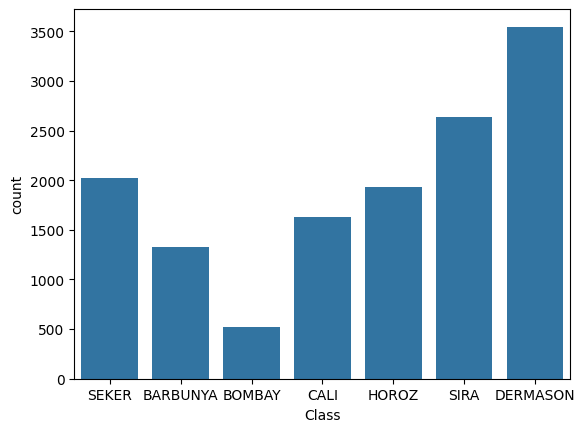

In [10]:
sns.countplot(x='Class', data = df)

In [11]:
# basic stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,13611.0,53048.284549,29324.095717,20420.000000,36328.000000,44652.000000,61332.000000,254616.000000
Perimeter,13611.0,855.283459,214.289696,524.736000,703.523500,794.941000,977.213000,1985.370000
MajorAxisLength,13611.0,320.141867,85.694186,183.601165,253.303633,296.883367,376.495012,738.860153
MinorAxisLength,13611.0,202.270714,44.970091,122.512653,175.848170,192.431733,217.031741,460.198497
AspectRation,13611.0,1.583242,0.246678,1.024868,1.432307,1.551124,1.707109,2.430306
Eccentricity,13611.0,0.750895,0.092002,0.218951,0.715928,0.764441,0.810466,0.911423
ConvexArea,13611.0,53768.200206,29774.915817,20684.000000,36714.500000,45178.000000,62294.000000,263261.000000
EquivDiameter,13611.0,253.064220,59.177120,161.243764,215.068003,238.438026,279.446467,569.374358
Extent,13611.0,0.749733,0.049086,0.555315,0.718634,0.759859,0.786851,0.866195
Solidity,13611.0,0.987143,0.004660,0.919246,0.985670,0.988283,0.990013,0.994677


In [12]:
# Store in different lists the names of the categorical and numerical columns since they will be treated different 
#categorical = df.select_dtypes(include=['object']).columns.tolist()  # for strings 
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist() # for numbers

<font size ='5'> ✌️ </font>No hay necesidad de más limpieza de datos. Vamos a codificar la clase que es categórica en datos numéricos con `LabelEncoder` y a escalarla con todas las 'features' con `StandardScaler`. 

<a name='prep-encoding'/> 

### <font color=#ac6240>2.2 Codificación y normalización de las 'features'</font>

In [13]:
labelencoder = LabelEncoder()
df["Class"] = labelencoder.fit_transform(df['Class'])
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,5


In [14]:
standardscaler = StandardScaler()
df_scaled = pd.DataFrame(standardscaler.fit_transform(
            df[['Area','Perimeter','MajorAxisLength','MinorAxisLength','AspectRation','Eccentricity',
            'ConvexArea','EquivDiameter','Extent','Solidity','roundness','Compactness','ShapeFactor1',
            'ShapeFactor2','ShapeFactor3','ShapeFactor4']]             
            ),columns = numerical)
df_scaled['Class']  = df['Class']
df_scaled

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,-0.840749,-1.143319,-1.306598,-0.631153,-1.565053,-2.185720,-0.841451,-1.063341,0.289087,0.367613,1.423867,1.839116,0.680786,2.402173,1.925723,0.838371,5
1,-0.829188,-1.013924,-1.395911,-0.434445,-1.969784,-3.686040,-0.826102,-1.044217,0.697477,-0.462907,0.231054,2.495449,0.367967,3.100893,2.689702,0.771138,5
2,-0.807157,-1.078829,-1.252357,-0.585735,-1.514291,-2.045336,-0.808704,-1.008084,0.578195,0.518417,1.252865,1.764843,0.603129,2.235091,1.841356,0.916755,5
3,-0.785741,-0.977215,-1.278825,-0.439290,-1.741618,-2.742211,-0.773975,-0.973337,0.671260,-2.241767,0.515049,2.081715,0.401718,2.515075,2.204250,-0.197985,5
4,-0.781239,-1.097384,-1.380471,-0.266663,-2.117993,-4.535028,-0.784286,-0.966080,0.476020,0.804772,1.874992,2.765330,0.118268,3.270983,3.013462,0.939640,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,-0.373471,-0.446083,-0.366669,-0.363055,-0.123703,0.153343,-0.378191,-0.364148,-0.716284,0.684173,0.727872,0.032433,0.261425,0.055630,-0.006086,0.760813,3
13607,-0.373334,-0.456336,-0.450053,-0.257015,-0.432979,-0.165141,-0.378662,-0.363962,1.022933,0.774384,0.818807,0.362794,0.110384,0.285117,0.328393,0.722659,3
13608,-0.372038,-0.447833,-0.450478,-0.246456,-0.448618,-0.182940,-0.376143,-0.362197,-0.403392,0.591370,0.758468,0.370533,0.104269,0.289204,0.336328,0.390251,3
13609,-0.371765,-0.427029,-0.428974,-0.266742,-0.380735,-0.106960,-0.372851,-0.361825,-0.903414,0.143717,0.581753,0.285098,0.141906,0.228375,0.248973,0.036440,3


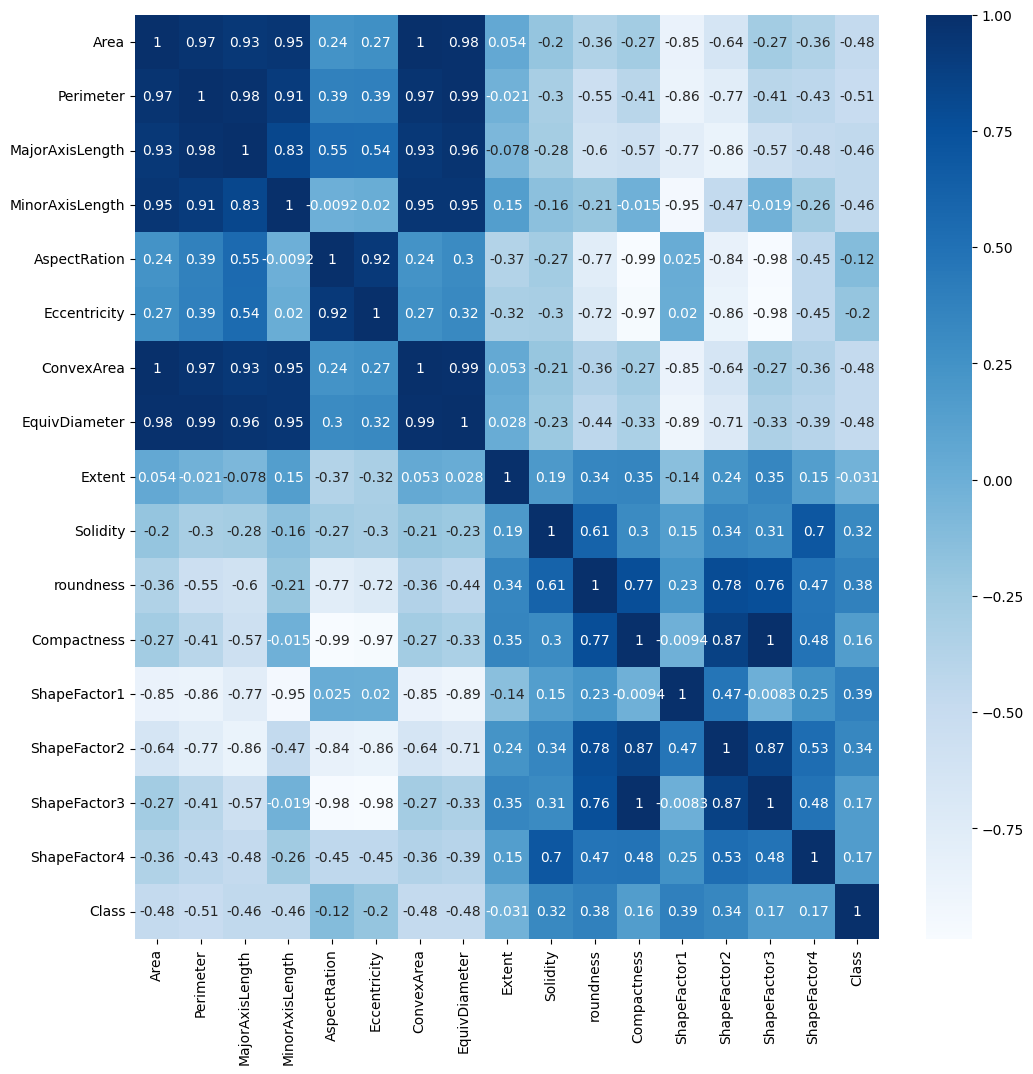

In [15]:
# See if there are relevant correlations
plt.figure(figsize=(12,12))
sns.heatmap(df_scaled.corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

No parece que ninguna 'feature' esté especialmente correlacionada con nuestra variable 'target'. Varias 'features' sí están muy correlacionadas. Por ejemplo, 'EquivDiameter' y 'Perimeter' están correlacionadas positivamente un 99% y 'ShapeFactor3' está correlacionada con positivamente con 'Compactness' un 100% y con 'AspectRation' y 'Eccentricity' negativamente un 98%.

In [16]:
# remove redundant features
df_scaled.drop(['EquivDiameter', 'Compactness', 'AspectRation','Eccentricity'], axis=1, inplace=True)

<a name='prep-split'/>

### <font color=#ac6240>2.3 División de los datos en conjuntos de datos de entrenamiento, validación y prueba</font>

En esta división aleatoria, y en todas las ocasiones siguientes en las que usemos un generador de números aleatorios, fijamos la semilla del generador de números aleatorios para asegurar la reproducibilidad de los resultados. Fijamos el `random_state = 1` pero podría ser 2 o cualquier otro valor, no afectará a los resultados, pero con esta corrección siempre obtendremos exactamente los mismos resultados.

In [17]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df_scaled.copy() 

#### For UQ we need to separate into 3 sets: the training, the calibration, and the test

In [18]:
# separate train + calibration (= full) and test
df_full_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
# now split the full into train and cal, it should be the 20% of the 80%, which is 20/80=1/4=0.25
df_train, df_cal = train_test_split(df_full_train, test_size=0.25, random_state=1) 
len(df_train), len(df_cal), len(df_test)

(8166, 2722, 2723)

Get the target and feature vectors for the train sets.

In [19]:
# reset index
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_cal = df_cal.reset_index(drop=True)

# define the target
y_train = df_train.Class.values
y_test = df_test.Class.values
y_cal = df_cal.Class.values

# remove the target from the features
del df_train['Class']
del df_test['Class']
del df_cal['Class']

# define the vector of features
X_train = df_train.values
X_test = df_test.values
X_cal = df_cal.values

<font size="5"> 👏 </font>  Ya tenemos todo para entrenar nuestro modelo de aprendizaje automático.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='model-ml'/>

## <font color=#ac6240>3. Entrenamiento y testado del modelo de aprendizaje automático</font>

In [20]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc.round(3)

0.902

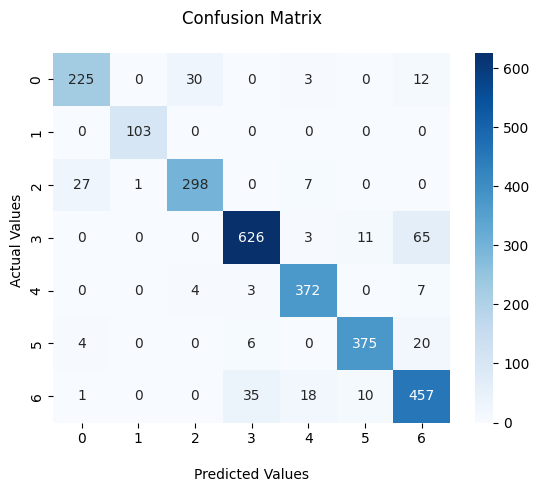

In [21]:
# confusion matrix

cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, fmt='0', annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

##plt.figure(figsize=(7,5))
plt.rcParams['figure.figsize'] = [7, 5]  # re-run this cell to get the correct figure size

plt.show();

La métrica de 'accuracy' divide los aciertos entre el número total de casos. Vemos del conjunto de test con 2723 alubias, (225 + 103 +298 + 626 + 372 + 375 + 457) = 2456 alubias han sido clasificadas correctamente, dándonos una 'accuracy' (2456/2723)= 0.902, como vimos en una celda anterior. Este valor nos indica que hay un 90.2% de probabilidad de que el resultado del modelo contenga efectivamente a la clase verdadera, no está mal.

#### ¿Pero y si quiero que el modelo prediga la clase verdadera el 95% de las veces? 

Empezamos ya a implementar métodos de UQ que permiten que nuestro modelo exprese la certeza de su predicción. Como veremos estos métodos nos permitirán reducir el número de Falsos Negativos o Positivos y estiar la distribución esperada de la predicción en lugar de un único valor puntual. Pero además nos garantizan la cobertura estadística, es decir, que el modelo prediga la clase verdadera el 95% de las veces. 

Por supuesto que debemos ajustar los hiperparámetros del modelo Gaussian Naive Bayes para optimizar la métrica de 'accuracy' (ver el Jupyter Notebook `Exploration_and_Classification.ipynb` en este mismo repositorio, allí tuneamos varios modelos para optimizar la exactitud). Sin embargo, no nos queremos centrar en ese trabajo ahora porque queremos demostrar que las métricas, por ejemplo 'accuracy', no indican la certeza que tiene el modelo sobre sus predicciones, sea cual sea el valor de dicha métrica. 

#### Es decir, ahora nos ocupamos de conseguir exactitud con certidumbre. 

![Molnar_UQ](./images/Molnar_UQ.png "Molnar_UQ")

[Fuente de la imagen](https://twitter.com/ChristophMolnar)

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='app-uq'/>

## <font color=#ac6240>4. Aplicación de métodos de cuantificacion de incertidumbre</font>

Veamos cómo implementar que el modelo prediga la clase verdadera el 95% de las veces. 

Una idea podría ser aceptar solo aquellas predicciones para las que la 'raw score', sea de la clase que sea, sea mayor que 0.95 y decidir descartar el resto. Esas alubias cuya puntuación quede por debajo del umbral de la clasificación automática habrán de ser clasificadas de otra manera, por ejemplo, por un ser humano. 

Comúnmente definimos ese umbral con el parámetro 'alpha'. Indica cuánta tolerancia, cuántos errores, es decir, predicciones que caen fuera el conjunto de predicción, estamos dispuestes a aceptar. Para una certeza del 95% de que la predicción del modelo contenga el valor correcto, establecemos que 'alpha' ha de ser igual a 0.05. Es importante notar que 'alpha' no es igual al umbral de decisión 't' que explicamos en la clasificación binaria del Jupyter Notebook `UQ.ipynb` porque aquí vamos a rechazar clasificar aquellas instancias que no alcancen una 'raw score' mayor o igual a 'alpha'. 

Veamos si esta idea inicial es efectiva o no:

In [22]:
# the output of .predict_proba() is a matrix: 
# left column is the results for neg ('0', no heart failure), right column is for pos ('1', heart failure)
# visualize just the raw scores and their correspondent the ground truth
df_raw_scores = pd.DataFrame({'Gtruth': y_test, 
                              'Rscor_class0': gnb.predict_proba(X_test)[:, 0].round(4), 
                              'Rscor_class1': gnb.predict_proba(X_test)[:, 1].round(4),
                              'Rscor_class2': gnb.predict_proba(X_test)[:, 2].round(4), 
                              'Rscor_class3': gnb.predict_proba(X_test)[:, 3].round(4),                              'Raw_scores_class_0': gnb.predict_proba(X_test)[:, 0].round(4), 
                              'Rscor_class4': gnb.predict_proba(X_test)[:, 4].round(4),                              'Raw_scores_class_0': gnb.predict_proba(X_test)[:, 0].round(4), 
                              'Rscor_class5': gnb.predict_proba(X_test)[:, 5].round(4),                              'Raw_scores_class_0': gnb.predict_proba(X_test)[:, 0].round(4), 
                              'Rscor_class6': gnb.predict_proba(X_test)[:, 6].round(4)})
df_raw_scores

,Gtruth,Rscor_class0,Rscor_class1,Rscor_class2,Rscor_class3,Raw_scores_class_0,Rscor_class4,Rscor_class5,Rscor_class6
0,6,0.0261,0.0,0.0020,0.0000,0.0261,0.972,0.0000,0.0000
1,3,0.0000,0.0,0.0000,0.0558,0.0000,0.000,0.0001,0.9441
2,3,0.0000,0.0,0.0000,0.9380,0.0000,0.000,0.0000,0.0619
3,6,0.0000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,1.0000
4,3,0.0000,0.0,0.0000,0.9865,0.0000,0.000,0.0135,0.0000
...,...,...,...,...,...,...,...,...,...
2718,3,0.0000,0.0,0.0000,1.0000,0.0000,0.000,0.0000,0.0000
2719,2,0.3512,0.0,0.6488,0.0000,0.3512,0.000,0.0000,0.0000
2720,6,0.0000,0.0,0.0000,0.8951,0.0000,0.000,0.0000,0.1049
2721,0,1.0000,0.0,0.0000,0.0000,1.0000,0.000,0.0000,0.0000


In [23]:
df_raw_scores.drop(['Raw_scores_class_0'], axis=1, inplace=True)

In [24]:
# choose alpha
alpha = 0.05
num_selected_beans = (gnb.predict_proba(X_test) >= 1.0 - alpha).sum()
num_discarded_beans = len(df_raw_scores) - num_selected_beans
# how many beans got a raw score in one of their potential classes higher or equal to alpha?
print('The number of beans with a raw score >=', 1.0 - alpha, 'is', num_selected_beans)
print('The number of beans that will be discarded is', num_discarded_beans)

The number of beans with a raw score >= 0.95 is 2483
The number of beans that will be discarded is 240


In [25]:
# select the beans with raw score higher or equal to 1 - alpha
df_alpha_select = df_raw_scores[
                    (df_raw_scores.Rscor_class0 >= 1. - alpha) | 
                    (df_raw_scores.Rscor_class1 >= 1. - alpha) | 
                    (df_raw_scores.Rscor_class2 >= 1. - alpha) | 
                    (df_raw_scores.Rscor_class3 >= 1. - alpha) | 
                    (df_raw_scores.Rscor_class4 >= 1. - alpha) | 
                    (df_raw_scores.Rscor_class5 >= 1. - alpha) | 
                    (df_raw_scores.Rscor_class6 >= 1. - alpha)
                  ]
#df_alpha_select.head()

In [26]:
# convert raw scores in class prediction
def select_class_alpha(Rscor_class0, Rscor_class1, Rscor_class2, Rscor_class3, 
                       Rscor_class4, Rscor_class5, Rscor_class6):
    if Rscor_class0 >= 1. - alpha:
        return 0
    elif Rscor_class1 >= 1. - alpha:
        return 1
    elif Rscor_class2 >= 1. - alpha:
        return 2
    elif Rscor_class3 >= 1. - alpha:
        return 3
    elif Rscor_class4 >= 1. - alpha:
        return 4
    elif Rscor_class5 >= 1. - alpha:
        return 5
    elif Rscor_class6 >= 1. - alpha:
        return 6
    else:
        return np.nan

df_alpha_select['AlphaPred'] = df_alpha_select.apply(lambda x: select_class_alpha(
                                    x.Rscor_class0, x.Rscor_class1, x.Rscor_class2, 
                                    x.Rscor_class3, x.Rscor_class4, 
                                    x.Rscor_class5, x.Rscor_class6), axis=1)
df_alpha_select.reset_index(drop = True)#.head()

,Gtruth,Rscor_class0,Rscor_class1,Rscor_class2,Rscor_class3,Rscor_class4,Rscor_class5,Rscor_class6,AlphaPred
0,6,0.0261,0.0,0.002,0.0000,0.9720,0.0000,0.0000,4
1,6,0.0000,0.0,0.000,0.0000,0.0000,0.0000,1.0000,6
2,3,0.0000,0.0,0.000,0.9865,0.0000,0.0135,0.0000,3
3,3,0.0000,0.0,0.000,1.0000,0.0000,0.0000,0.0000,3
4,6,0.0000,0.0,0.000,0.0000,0.9989,0.0000,0.0011,4
...,...,...,...,...,...,...,...,...,...
2478,3,0.0000,0.0,0.000,1.0000,0.0000,0.0000,0.0000,3
2479,3,0.0000,0.0,0.000,0.9999,0.0000,0.0000,0.0001,3
2480,3,0.0000,0.0,0.000,1.0000,0.0000,0.0000,0.0000,3
2481,0,1.0000,0.0,0.000,0.0000,0.0000,0.0000,0.0000,0


In [27]:
# percentage of well classifies ones
acc_select = accuracy_score(np.array(df_alpha_select.Gtruth), np.array(df_alpha_select.AlphaPred))

print('With alpha =', 1. - alpha,'we got an accuracy of', acc_select.round(3),'and we have discarded', 
      num_discarded_beans, 'beans')

With alpha = 0.95 we got an accuracy of 0.938 and we have discarded 240 beans


Vemos entonces que nuestra primera idea era un poco ingenua. Al aplicarla hemos mejorado el anterior porcentaje de 90.2% pero solo hemos conseguido clasificar correctamente el 93.8% de las alubias y hemos tenido que descartar 240.

Esto sucede porque hemos seleccionado las alubias con 'raw scores' por encima o iguales a 0.95 pero sin tener en cuenta su clase real, es decir, no hemos comprobado qué 'raw score' tenía la 'ground truth'. 

Este es el dataframe con las 'features', la clase verdadera 'Gtruth', y la predicción para el conjunto de test que vamos a tomar como nuevas alubias:

In [28]:
df_new = df_test
df_new['GTruth'] = y_test
df_new['Pred'] = y_pred
# reorder columns just to see them better
new_cols = ['GTruth', 'Pred'] 
new_cols = new_cols + df_test.columns.to_list()
df_new = df_new[new_cols]
df_new

,GTruth,Pred,Area,Perimeter,MajorAxisLength,MinorAxisLength,ConvexArea,Extent,Solidity,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,GTruth,Pred
0,6,4,0.156727,0.289187,0.469619,0.056864,0.158757,-1.472021,-0.362880,-0.206874,-0.276356,-0.812922,-0.792786,-0.178806,6,4
1,3,6,-0.467288,-0.545023,-0.467073,-0.514572,-0.470386,0.924790,0.508565,0.559789,0.492696,0.124453,-0.051893,0.761050,3,6
2,3,3,-0.516157,-0.627844,-0.599101,-0.486767,-0.518549,-0.025124,0.429971,0.736733,0.466703,0.396157,0.247350,0.115062,3,3
3,6,6,-0.305742,-0.221416,-0.090540,-0.491110,-0.299968,0.505140,-0.849600,-0.410448,0.463358,-0.452826,-0.691044,0.483760,6,6
4,3,3,-0.617988,-0.761051,-0.875928,-0.448765,-0.618201,0.955230,0.119268,0.718003,0.401957,1.102026,0.977599,0.325987,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,3,3,-1.014162,-1.344750,-1.209686,-1.439046,-1.015362,1.163722,0.689404,0.629205,2.414548,0.976156,-0.103997,0.362046,3,3
2719,2,2,0.465324,0.607357,0.627435,0.567018,0.456535,1.193231,0.630967,-0.171796,-0.848624,-0.738658,-0.365763,0.463147,2,2
2720,6,3,-0.541461,-0.622915,-0.619251,-0.530782,-0.540616,1.026111,-0.094812,0.390981,0.550995,0.394742,0.201102,-0.405900,6,3
2721,0,0,0.526948,0.708677,0.224936,1.226325,0.528578,0.340245,-0.346855,-0.414116,-1.426134,0.060210,1.146309,0.725296,0,0


Por ejemplo, tomemos una alubia del conjunto de test, vamos a ponerla como ejempo de una nueva alubia que queremos clasificar:

In [29]:
n = 1

print('Predicted class', y_pred[n])
print('True class', y_test[n])
print('with raw scores per class:')
# raw scores of the predicted classes
keys = ['class 0', 'class 1','class 2','class 3', 'class 4','class 5', 'class 6']
dict(zip(keys, gnb.predict_proba(X_test[n].reshape(1, -1)).T.round(4)))

Predicted class 6
True class 3
with raw scores per class:


{'class 0': array([0.]),
 'class 1': array([0.]),
 'class 2': array([0.]),
 'class 3': array([0.0558]),
 'class 4': array([0.]),
 'class 5': array([0.0001]),
 'class 6': array([0.9441])}

Vamos a probamos ahora otra idea, que va a terner en cuenta los valores verdaderos y se va a centrar en encontrar el umbral para que se cumpla la garantía de cobertura. Para ello nos va a proveer de un intervalo de predicción alredor del resultado y este intervalo sí va a contener a la clase verdadera con un 95% de probabilidad.

<a name='uq-cp'/>

### <font color=#ac6240>4.1 Conformal Predictors</font>

La ['Conformal Prediction'](https://en.wikipedia.org/wiki/Conformal_prediction) es un método para cuantizar la rareza de una predicción respecto al resto de valores de la variable de destino o 'target'. Recibe su nombre de la denominama medida de no conformidad, o 'nonconformity measure' que cuantiza cuán diferente es la  predicción dentro del conjunto de predicciones que obtuvimos al predecir el conjunto de entrenamiento. Una alta 'nonconformity' indica que el nuevo dato es raro, como le pájare en el ejemplo de la Introducción. Les cientifiques de datos que aplicamos la 'Conformal Prediction' nos llamamos 'nonconformists'.

<font size="5">😎<font/>

La 'Conformal Prediction':

+ funciona para cualquier modelo de aprendizaje automático,
+ se aplica en el 'post-procesing' sobre las predicciones del modelo de aprendijaze automático ya entrenado,
+ requiere pocas líneas de código y es rápida, 
+ funciona para datos recogidos en tiempo real, es decir, 'online assimilation',
+ es 'model-agnostic' y ni siquiera necesita conocer al modelo de aprendizaje automático para el que está cuantizando la incertidumbre de sus predicciones,     
+ ofrece una garantía de cobertura: los conjuntos de predicciones resultantes vienen con garantías de cubrir el resultado verdadero con una probabilidad determinada,
+ a diferencia de los métodos paramétricos, no es necesario asumir que la variable de destino o 'target' está distribuida según una distribución normal, y 

de hecho, la unica condición es que las instancias sean [intercambiables](https://en.m.wikipedia.org/wiki/Exchangeable_random_variables), es decir, que el orden de los datos no importe, (como en nuestro caso, la alubias no tienen que estar ordenadas) lo cual es una restricción menos fuerte que la restricción que tienen todos los modelos de aprendizaje automático sobre que los datos han de ser independientes e estar idénticamente distributidos, o [iid](https://es.wikipedia.org/wiki/Variables_aleatorias_independientes_e_id%C3%A9nticamente_distribuidas). 

Así, la 'Conformal Prediction' nos cuantifica la incertidumbre en forma de intervalos de predicción, también llamados 'conformal intervals', que con la garantía de que el intevalo incluye la prediccion correcta con cierta probabilidad, lo cual se llama 'coverage guarantee'. Entonces, en lugar de obtener predicciones puntuales ('single-point predictions'), es decir, un número real en el caso de una regresión o la etiqueta de una clase en el caso de una clasificación, los resultados calibrados con 'Conformal prediction' nos dan un intervalo de números reales o un conjunto de etiquetas, respectivamente.
    
En ejemplo justo aquí debajo vemos que aplicando 'Conformal Prediction' a los resultados de un modelo de aprendizaje automático (una Deep Neural Network en PyTorch) para una clasificación de imágenes, vemos que éste:
    
+ no está muy seguro de si la primera foto era un osciloscopio, así que nos lo ofrece como primera opción en un intervalo con otras dos opciones, 'microondas' y 'portátil', 
+ tampoco está muy seguro de la foto central, de nuevo nos dió la respuesta correcta como primera opción pero el intervalo contiene también 'refrigerador' y ' lavadora', y
+ está muy seguro de que en la foto de la derecha hay unx perre de raza 'Irish Setter' (seguro que ha visto muchos como ese, para el modelo no es para nada una imagen rara), y es la única opción del intervalo de resultados:

![CP_example](./images/CP_4.png "CP_example")

[Fuente de la imagen: Google Colab de A. Angelopoulos desarrollador de MAPIE](https://colab.research.google.com/github/aangelopoulos/conformal_classification/blob/master/example.ipynb#scrollTo=oIiBD-pFVdkD)

Recordamos que el intervalo de predicción que obtenemos con la 'Conformal Prediccion' no es un mero ranking de las 'raw scores' de cada clase si no una verdadera probabilidad con ganarantías estadísticas de que la verdadera clase está dentro de ese intervalo.

<font color=#6B8E23 size="4"> Material adicional y referencias</font>

<font color=#6B8E23 size="3"> Cursos, charlas, y blogs

+ El curso gratuito de Christoph Molnar (subscríbete [aquí](https://substack.com/sign-in?redirect=%2Faccount%3Futm_source%3Dsubstack%26utm_medium%3Demail&for_pub=mindfulmodeler&email=&with_password=&change_user=false&justTrying=)), el autor del maravilloso libro gratuito sobre XAI [_"Interpretable Machine Learning"_](https://christophm.github.io/interpretable-ml-book/), que recomendamos en el Jupyter Notebook `XAI.ipynb`, que ahora se ha pasado a la UQ y ha publicado un libro sobre Conformal Prediction [_"Introduction To Conformal Prediction With Python. A Short Guide For Quantifying Uncertainty Of Machine Learning Models"_](https://christophmolnar.com/books/conformal-prediction/) <font size="3">♫♫🎈♫♫</font>.
+ La maravillosa charla _"Quantifying uncertainty in Machine Learning predictions"_ de [Maria Navarro](https://youtu.be/r6bhm_A-YcQ).
+ La charla sobre Conformal Predictors en el [curso sobre incertidumbre de la Universidad de Pennsylvania](https://uncertaintyclass.com/), este es el [vídeo](https://youtu.be/M3tkM4dcIPA).
+ El blog de los creadores de los 'Conformal Predictors'  [Prof. Vladimir Vovk y Prof. Alex Gammerman](https://cml.rhul.ac.uk/cp.html).
+ Este [kernel de Kaggle](https://www.kaggle.com/code/carlmcbrideellis/regression-prediction-intervals-with-mapie) que explica como usar los Conformal Predictors en una tarea de regresión.
+ El repositorio ['Awesome Conformal Prediction'](https://github.com/valeman/awesome-conformal-prediction) y los artículos de Medium de Valeriy Manokhin del grupo de investigación que creó la 'Conformal Prediction'.
    
<font color=#6B8E23 size="3"> Libros

+ De nuevo el libro de Christoph Molnar [_"Introduction To Conformal Prediction With Python. A Short Guide For Quantifying Uncertainty Of Machine Learning Models"_](https://christophmolnar.com/books/conformal-prediction/).    
+ El libro de Valeriy Manokhin [_"Practical Guide to Applied Conformal Prediction in Python: Learn and apply the best uncertainty frameworks to your industry applications "_](https://www.amazon.com/Practical-Guide-Applied-Conformal-Prediction/dp/1805122762) (enlace a Amazon, sorry, hasta ahora solo se encuentra ahí).

<font color=#6B8E23 size="3">Librerías</font>

+ Los paquetes de Python, compatibles con Scikit-learn, que incluyen buenos tutoriales y que se pueden instalar fácilmente con `pip install`:
    + [MAPIE](https://github.com/scikit-learn-contrib/MAPIE),
    + [CREPES](https://github.com/henrikbostrom/crepes), 
    + [PUNCC](https://github.com/deel-ai/puncc),
    + [TorchCP](https://github.com/ml-stat-Sustech/TorchCP) especialmente para Deep Learning, y
    + [nonconformist](https://github.com/donlnz/nonconformist/blob/master/README.ipynb).
+ Teoría y ejemplos en el repositorio [A. Angelopoulos](https://github.com/aangelopoulos/conformal-prediction), uno de los dos autores de [_"A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification_"](https://arxiv.org/abs/2107.07511).
+ El 'framework' de IBM [AIF360](https://github.com/Trusted-AI/AIF360/blob/master/examples/README.md) para mitigar sesgos y que también recomendamos en el Jupyter Notebook `XAI.ipynb`, incluye técnicas como la clasificación con opción de rechazo o 'Reject Option-based Classification' (ROC), también llamada 'Selective Prediction', un método que asume que el modelo de aprendizaje automático asignó 'raw scores' cercanas al valor del umbral de decisión a aquellas predicciones de las que estaba menos seguro, como por ejemplo, la de le perre que parecía un poco une gate en la foto central de las imágenes de la sección <a href=#project-description-intro>1.1 Introducción</a>) y las separa en una nueva clase, es decir, los resultados posibles son '0', '1', y 'no tengo ni idea'.
+ El 'framework' de IBM [UQ360](https://uq360.mybluemix.net/) con muchos métodos de UQ e incluye [tutoriales](https://uq360.mybluemix.net/resources/tutorials) y una [guía de algoritmos y métricas](https://uq360.mybluemix.net/resources/guidance).

Seguimos los pasos del blog de [Christoph Molnar](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal) para darle garantía de cobertura a la clasificación de nuestras alubias. 


<font size="6">🚀</font>

In [30]:
# predict the calibration set
y_pred_cal = gnb.predict_proba(X_cal)

# take the raw scores of the true class
# try it:
# a = np.arange(2)
# b = y_cal[0:2] <-- clase verdadera
# c = y_pred_cal[0:2,:] <-- clase predicha
# c[a,b]  <-- va por c y si b es "3" pues coje de c el valor en la posicion 3
rscor_true_class = y_pred_cal[np.arange(len(y_cal)),y_cal] 

# define a non conformity measure here we chose the HINGE LOSS probability of not predicting the true class
S = 1. - rscor_true_class 

# find the (1 - alpha)-th quantile of S 
# given a vector V, the q-th quantile of V is the value q of the 
# way from the minimum to the maximum in a sorted copy of V
small_sample = (len(y_cal)+1)/len(y_cal) # finite sample correction, i.e. (n+1)/n
qhat = np.quantile(S, (1. - alpha)*small_sample) 
qhat.round(4)

0.9966

Tomemos una alubia de ejemplo

In [31]:
df_new.tail()

,GTruth,Pred,Area,Perimeter,MajorAxisLength,MinorAxisLength,ConvexArea,Extent,Solidity,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,GTruth,Pred
2718,3,3,-1.014162,-1.344750,-1.209686,-1.439046,-1.015362,1.163722,0.689404,0.629205,2.414548,0.976156,-0.103997,0.362046,3,3
2719,2,2,0.465324,0.607357,0.627435,0.567018,0.456535,1.193231,0.630967,-0.171796,-0.848624,-0.738658,-0.365763,0.463147,2,2
2720,6,3,-0.541461,-0.622915,-0.619251,-0.530782,-0.540616,1.026111,-0.094812,0.390981,0.550995,0.394742,0.201102,-0.405900,6,3
2721,0,0,0.526948,0.708677,0.224936,1.226325,0.528578,0.340245,-0.346855,-0.414116,-1.426134,0.060210,1.146309,0.725296,0,0
2722,2,2,1.093977,1.283130,1.445359,0.989239,1.099382,-0.238480,-0.649553,-0.602659,-1.195008,-1.247552,-0.947264,-1.317952,2,2


In [32]:
n = 1

print('Predicted class', y_pred[n])
print('True class', y_test[n])
print('Prediction set:')
prediction_sets = (1 - gnb.predict_proba(X_test[n].reshape(1, -1)) <= qhat) 
prediction_sets

Predicted class 6
True class 3
Prediction set:


array([[False, False, False,  True, False, False,  True]])

El conjunto de predicción es entonces [3,6] que vemos que incluye la clase verdadera, la 3.

Podemos usar el paquete 'MAPIE' sobre la misma alubia:

In [33]:
# fit the CP with the calibration set
cp = MapieClassifier(estimator = gnb, cv="prefit",  method="score") # prefit bcs we use the previous gnb
cp.fit(X_cal, y_cal)

MapieClassifier(cv='prefit', estimator=GaussianNB(), method='score')

In [34]:
# apply to the new bean
n = 1

y_pred, y_set = cp.predict(X_test[n].reshape(1, -1), alpha=alpha) # y_pred is equal to the previous y_pred from gnb

print('Predicted class', y_pred)
print('True class', y_test[n])
print('Prediction set:')
print(y_set)

Predicted class [6]
True class 3
Prediction set:
[[[False]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [ True]]]


La predicción sigue siendo la clase 6, lo cual es incorrecto, sabemos que la nueva alubia es clase 3, pero ahora al conformalizar la predicción obtenemos un intervalo de predicción ('prediction interval') en forma de conjunto de predicciones ('prediction set') el cual contiene a la clase verdadera un 95% de las veces. El conjunto de predicción es entonces [3,6] que vemos que incluye la clase verdadera, la 3.

In [35]:
# apply to another new bean
n = 0

y_pred, y_set = cp.predict(X_test[n].reshape(1, -1), alpha=alpha) # same y_pred as the one we got for gnb

print('Predicted class', y_pred_cal)
print('True class', y_test[n])
print('Prediction set:')
print(y_set)

Predicted class [4]
True class 6
Prediction set:
[[[ True]
  [False]
  [False]
  [False]
  [ True]
  [False]
  [False]]]


y el 'prediction set' es [0,4] que no incluye a la clase verdadera. Recordemos que la confianza nunca es del 100% porque para ello cada 'prediction set' sería el conjunto completo, es decir, todas las clases, y el resultado no sería para nada informativo.

In [36]:
# apply to another new bean
n = 2720

y_pred, y_set = cp.predict(X_test[n].reshape(1, -1), alpha=alpha) # same y_pred as the one we got with gnb

print('Predicted class', y_pred)
print('True class', y_test[n])
print('Prediction set:')].
print(y_set)

Predicted class [3]
True class 6
Prediction set:
[[[False]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [ True]]]


In [57]:
n = 2622

y_pred, y_set = cp.predict(X_test[n].reshape(1, -1), alpha=alpha) # same y_pred as the one we got with gnb

print('Predicted class', y_pred)
print('True class', y_test[n])
print('Prediction set:')
print(y_set)

Predicted class [3]
True class 6
Prediction set:
[[[False]
  [False]
  [False]
  [ True]
  [False]
  [ True]
  [ True]]]


El modelo no está muy seguro de la predicción de la clase de esta alubia, el conjunto de clasificación contiene 3 clases, es ancho: [3,5,6]. Si el intervalo de predicción es grande, esa predicciones tiene incerticumbre. En aplicaciones reales, puede ser preferible esa inversión en tiempo humano en lugar de asumir las clasificaciones incorrectas. Con los CP identificamos las clasificaciones inciertas, si implementamos un protocolo de 'fallback' para estos casos, el programa nos dirá 'no puedo predecir, no tengo ni idea' y una persona se encargará de clasificar estas instancias. Veamos cuáles fueron sus 'raw scores':

In [60]:
print('Raw scores per class:')
# raw scores of the predicted classes
keys = ['class 0', 'class 1','class 2','class 3', 'class 4','class 5', 'class 6']
dict(zip(keys, gnb.predict_proba(X_test[n].reshape(1, -1)).T.round(4)))

Raw scores per class:


{'class 0': array([0.]),
 'class 1': array([0.]),
 'class 2': array([0.]),
 'class 3': array([0.4253]),
 'class 4': array([0.]),
 'class 5': array([0.3723]),
 'class 6': array([0.2025])}

Si no utilizamos herramientas de cuantificación de incertidumbre, nos quedamos con que el resultado es la clase 3 con la misma confianza que nos da un resultado de una alubia bien clasificada porque sin conjuntos de predicción no habríamos podido distinguirlo.

Como último ejemplo, veamos qué conjunto de predicción tiene una alubia bien clasificada:

In [37]:
# apply to another new bean, a well classified one
n = 30

y_pred, y_set = cp.predict(X_test[n].reshape(1, -1), alpha=alpha) # y_pred is equal to the previous y_pred

print('Predicted class', y_pred)
print('True class', y_test[n])
print('Prediction set:')
print(y_set)

Predicted class [3]
True class 3
Prediction set:
[[[False]
  [False]
  [False]
  [ True]
  [False]
  [False]
  [False]]]


El conjunto de predicción solo incluye una clase, la verdadera. Un conjunto de predicción pequeño indica que hay confianza en el resultado. 

Vamos a comprobar la cobertura de los conjuntos de predicción, es decir, vamos a ver cuántas veces recogieron de verdad la clase correcta. Usamos la métrica `classification_coverage_score` de [MAPIE](https://mapie.readthedocs.io/en/latest/examples_classification/4-tutorials/plot_main-tutorial-binary-classification.html?highlight=accuracy#conformal-prediction-method-using-the-softmax-score-of-the-true-label) que calcula la cobertura como la 'accuracy'. La comparamos con la 'accuracy' que obtuvimos en la primera idea naive.

In [108]:
# prediction sets for all the beans
y_pred, y_set = cp.predict(X_test, alpha=alpha) # same y_pred as the one we got with gnb

# metric to get the accuracy = coverage
cp_acc = classification_coverage_score(y_test, y_set[:, :, 0])

print('CP approach: with alpha =', 1. - alpha,'we got an accuracy of', round(cp_acc, 3),'and we have discarded 0 beans')

CP approach: with alpha = 0.95 we got an accuracy of 0.962 and we have discarded 0 beans


In [107]:
# percentage of well classifies ones from the naive approach we explained at the beginning of the section
acc_select = accuracy_score(np.array(df_alpha_select.Gtruth), np.array(df_alpha_select.AlphaPred))
print('Naive approach: with alpha =', 1. - alpha,'we got an accuracy of', acc_select.round(3),'and we have discarded', 
      num_discarded_beans, 'beans')

Naive approach: with alpha = 0.95 we got an accuracy of 0.938 and we have discarded 240 beans


Vemos que ahora ya obtenemos de sobra la cobertura desdeada sin deaprovechar ninguna alubia.

<font size="5"> 🥳 </font>

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='uq-end'/>

### <font color=#ac6240>5. Conclusión sobre la cuantificación de incertidumbre</font>

Con los métodos de UQ hemos visto que podemos identificar aquellas clasificaciones inciertas y dar un conjunto de predicción que nos asegura contener la clase correcta un (1-alpha)% de las veces. 

Vemos que son métodos fáciles de implementar y rápidos, y nos proporcionan certudumbre en las predicciones. Aquí lo hemos aplicado a una tarea de clasificación pero los CP pueden aplicarse a cualquier tipo de tarea.


<font size="5">🎈♫♫🎈🎈♫🎈♫♫♫♫🎈🎈 ♫♫♫ 🎈🎈</font>

<a href=#toc>Subir a Tabla de Contenidos</a><br>

Ya no queda tiempo para más, nos vemos en el próximo taller. 

<font size="5">☀️⛱️ </font> Buen trabajo y hasta pronto!

